In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf
from stock_data import StockData
import datetime
from hmmlearn import hmm
from matplotlib.dates import YearLocator, MonthLocator


ticker = 'SPY'
end_date = datetime.date.today()
start_date = pd.to_datetime(end_date) - pd.DateOffset(months=6*12)
data_interval = '1d'

stock = StockData(ticker, start_date, end_date, data_interval)
data = stock.history

data['Date'] = stock.history.index.values

stock.candlestick

In [52]:
returns_ratio = np.divide(data["Close"].shift(1).values.tolist(),data["Close"].values.tolist())
log_returns = np.log(returns_ratio)
log_returns_df = pd.DataFrame(log_returns).set_index(data.index).dropna()
X = log_returns_df.values.reshape(-1, 1)


best_score = None
try_components = [2, 3, 4, 5]

for n in try_components:
    for i in range(10):
        try_model = hmm.GaussianHMM(n_components=n, covariance_type="diag", n_iter=1000)
        try_model.fit(X)
        score = try_model.aic(X)
        if best_score is None or score < best_score:
            best_score = score
            model = try_model
        #print("{} Components on Iteration {}, AIC: {}".format(n, i+1, score))

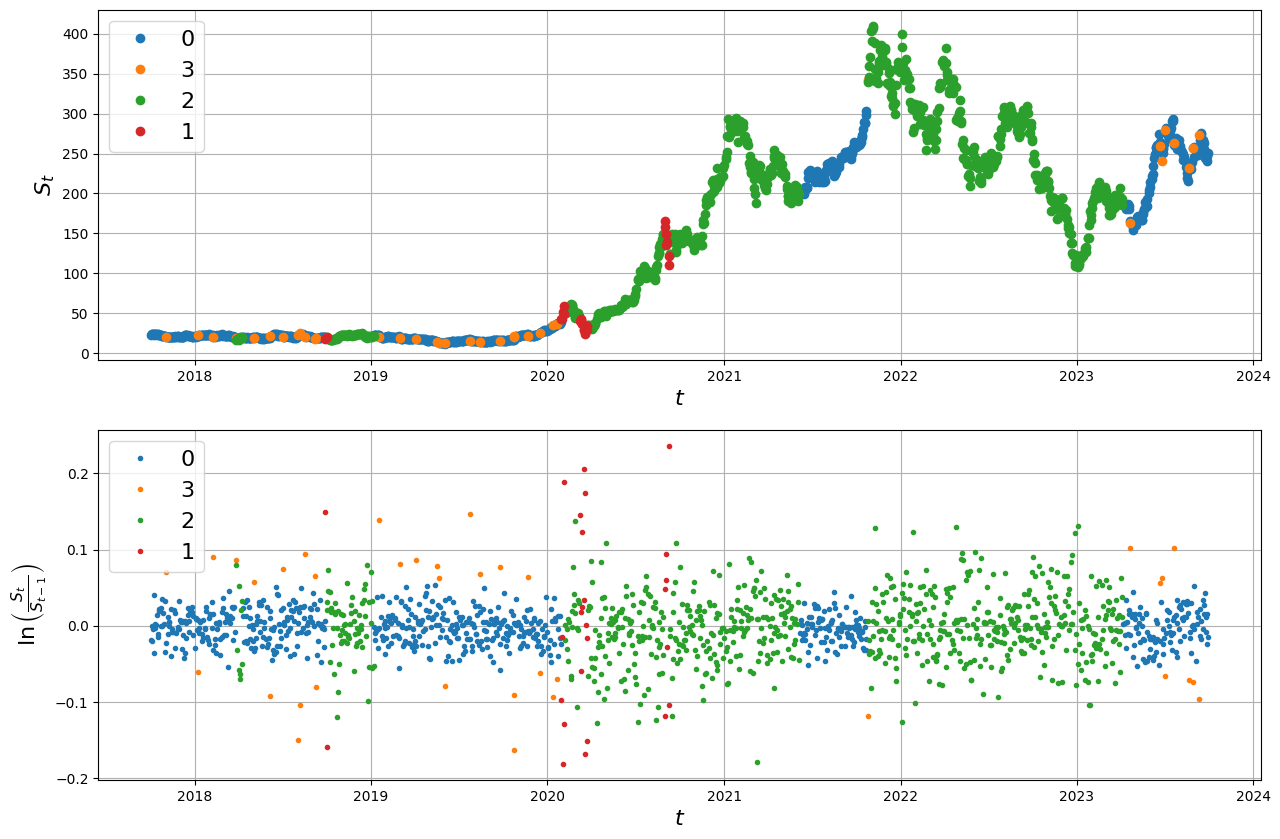

In [53]:
Z=model.predict(X)
states=pd.unique(Z)

plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (Z == i)
    y = data["Close"].tail(-1).iloc[want]
    x = data["Date"].tail(-1).iloc[want]
    plt.plot(x, y, '.', linewidth=2, markersize=12)
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$S_t$', fontsize=16)
plt.subplot(2,1,2)
for i in states:
    want = (Z == i)
    y = log_returns_df.iloc[want]
    x = data["Date"].tail(-1).iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\ln\left(\frac{S_t}{S_{t-1}}\right)$', fontsize=16)
plt.show()

In [54]:
for state in range(len(states)):
    print("State {}: Mean = {}".format(state, model.means_[state][0]))

State 0: Mean = -0.0017729969275203051
State 1: Mean = 0.005908858254373881
State 2: Mean = -0.0025587113514059126
State 3: Mean = 0.0011552575327160935


In [55]:
for state in range(len(states)):
    print("State {}: Covariances = {}".format(state, model.covars_[state][0]))

State 0: Covariances = [0.00048854]
State 1: Covariances = [0.01025025]
State 2: Covariances = [0.00204583]
State 3: Covariances = [0.00364473]
